In [2]:
import pandas as pd
import numpy as np

import librosa
import librosa.display
import librosa.segment

import matplotlib.pyplot as plt

In [3]:
'''
Description:
    Plots the boundaries along with signal waveform. 
Parameters:
    waveform (numppy.ndarray): array of signal amplitudes
    boundaries (numppy.ndarray): array of waveform indices where boundaries exist
    sr (int): sample rate of waveform
Return:
    None

'''
def plot_boundaries_on_waveform(waveform, boundaries, sr):
    hi, lo = max(waveform), min(waveform) 
    no_samples = len(waveform)
    plt.vlines(boundaries/sr, lo, hi, colors='Red', linestyles='dotted')
    plt.plot(np.linspace(0, no_samples/sr, no_samples), waveform)

In [4]:
'''
Description:
    Splices a signal to [t1, t2), and optionally adjusts the boundary indices to the spliced signal.
Parameters:
    signal (numpy.ndarray): signal to splice
    t1 (int/float): lower bound in seconds
    t2 (int/float): upper bound in seconds
    boundaries (numpy.array): list of boundaries
Return:
    s_signal (numpy.array): spliced signal
    s_boundaries (numpy.array): boundaries adjusted to spliced signal 
'''
def signal_splice(signal, t1, t2, sr, boundaries=[]):
    t1 = int(t1*sr)
    t2 = int(t2*sr)
    signal = signal[t1:t2]
    boundaries = boundaries[(boundaries >= t1) & (boundaries <= t2)]
    return signal, boundaries

In [5]:
'''
Description:
    Computes the windowed version of the non-linear energy operator (w-NLEO), 
    then returns an array containing boundary positions.
Parameters:
    data (numppy.ndarray): signal array
    window_size (int): size of windows to perform NLEO operation.
    threshold (float): minimum threshold for considering boundaries.
Return:
    array of segment positions

'''
def nonlinear_energy_operator(data, window_size, threshold):
    assert window_size > 1
    N = window_size//2
    w_nleo = [] # psi_n
    
    for n in range(3+N, len(data)-N):
        w_nleo.append(sum(data[n-1-N : n-1+N])*sum(data[n-2-N : n-2+N]) - sum(data[n-N : n+N])*sum(data[n-3-N : n-3+N]))
    w_nleo = [w_nleo[0]]*(3+N) + w_nleo + [w_nleo[len(w_nleo)-1]]*(N) # padding nleo values with first and last values
    assert len(w_nleo) == len(data) 

    boundaries = [] #index of found boundaries in data array 
    for n in range(N-1, len(data)-N-1):
        gnleo = sum(w_nleo[n-N+1 : n]) - sum(w_nleo[n+1 : n+N]) #max is n+N, min
        if (gnleo > threshold):
            boundaries.append(n)
    boundaries = np.array(boundaries, dtype='int')
    return boundaries, w_nleo #only return w_nleo for analysis plz

In [6]:
# loads an audio file as an numpp array containing signal amplitudes
sample, sr = librosa.load("data/processed/67375127.140411201837_002510_002518.wav",sr=48000)

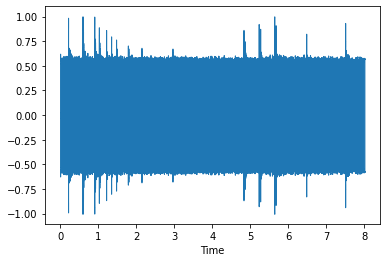

In [7]:
librosa.display.waveshow(sample, sr=sr)

In [8]:
boundaries_nleo, w_nleo = nonlinear_energy_operator(sample, 10, 0.3)
print("Number of boundaries: ", len(boundaries_nleo))
print("Boundary locations: ", boundaries_nleo)

Number of boundaries:  36
Boundary locations:  [ 10126  10127  10128  10129  10130  10131  10132  10133  10134  10135
  10136  28361  28362  28363  28364  28365  28366  28367  28368  28369
  43170  43171  43172  43173  43174  43175  43176  43177  43178 359682
 359683 359684 359685 359686 359687 359688]


> TODO: fix boundary alignment when splicing with t1 not equal to 0
* a signal array does not preserve a notion of absolute time
* when a signal is spliced the time range becomes 0 to length of spliced signal.
* the logic for filtering boundaries preserves the notion of time relative to the non-spliced signal.
* this boundary value needs to be adjusted so that the boundary represents the index of the spliced signal. 

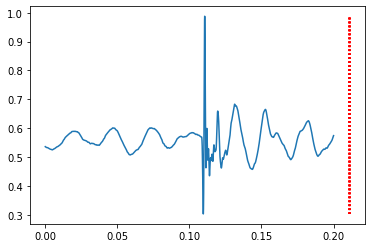

In [9]:
subsig, subbounds = signal_splice(sample, 0.1, 0.3, sr, boundaries_nleo)
plot_boundaries_on_waveform(subsig, subbounds, sr)